# Let's have a look at the data!

In this recap, we'll work with this dataset from Kaggle: https://www.kaggle.com/datasets/saurabhbagchi/dish-network-hackathon?select=Train_Dataset.csv

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

data = pd.read_csv("data/Train_Dataset.csv")

In [ ]:
data.head()

In [ ]:
X = data.drop(columns=["Default", "ID"])
y = data.Default

In [ ]:
y.value_counts(normalize = True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [ ]:
X_train.dtypes

In [ ]:
# Unfortunately we get an error here!
X_train["Client_Income"].astype(float)

In [ ]:
col_to_fix = ["Score_Source_3", 
              "Client_Income", 
              "Credit_Amount", 
              "Loan_Annuity", 
              "Age_Days",
              "Employed_Days",
              "Registration_Days",
              "ID_Days",
              "Population_Region_Relative"
             ]

# Building the pipeline and fixing that type!

In [ ]:
import string

print(string.punctuation)
print(string.ascii_letters)

In [ ]:
string.punctuation.replace(".", "") + string.ascii_letters

In [ ]:
def clean_df(X):
    
    def clean_value(value):
        unwanted_char = string.punctuation.replace(".", "") + string.ascii_letters 
        for tag in unwanted_char:
            value = value.replace(tag, "")
        value = np.nan if not value else value
        return float(value)
    
    X = pd.DataFrame(X)
    X = X.astype(str).applymap(clean_value)
    return X
        

In [ ]:
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

In [ ]:
cleaner = FunctionTransformer(clean_df)

type_cleaner = ColumnTransformer(
    [("type_cleaner", cleaner, col_to_fix)],
    remainder = "passthrough").set_output(transform = "pandas")

In [ ]:
type_cleaner.fit_transform(X_train)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
num_preproc = Pipeline([
    ("num_imputer", SimpleImputer(strategy = "constant", fill_value=0.)),
    ("scaler", StandardScaler())
])

In [ ]:
cat_preproc = Pipeline([
    ("cat_imputer", SimpleImputer(strategy = "constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output=False))
])

In [ ]:
preproc = ColumnTransformer([
    ("num_tr", num_preproc, make_column_selector(dtype_include = ["float64", "int64"])),
    ("cat_tr", cat_preproc, make_column_selector(dtype_include = ["object"]))
])

In [ ]:
clean_preproc = Pipeline([
    ("cleaner", type_cleaner),
    ("preprocessing", preproc)])

In [ ]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("clean_preproc", clean_preproc),
    ("classifier", LogisticRegression(max_iter = 1000))
])
    
pipe

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(pipe, X_train, y_train).mean()

# Wait, are we doing things correctly?

## What's wrong with cross validation?

When tackling imbalanced datasets 🌓, let's arm ourselves with Stratified K-Fold Cross-Validation! 🛡️🔄

Why, you ask? 🤔

1. Regular K-Fold 🔄: Might leave out the minority class in some folds 😨! Leads to less reliable model evaluation. 😢


2. Stratified K-Fold 🔀: Makes sure that each fold ⚙️ has a good proportion of both majority and minority classes. 🎉


3. Reliable Evaluation 🎯: More representative of real-world performance. 🌍 Keeps both classes in check! 🤹‍♂️


Better Model Tuning 🚀: Parameters honed with a clearer understanding of how your model handles the minority class! 🕵️‍♀️

In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 5)

cross_val_score(pipe, X_train, y_train, cv = cv).mean()

## What's wrong with accuracy?

For imbalanced datasets 🌓, precision-recall AUC 📈 is king! 🤴

Why? 🤔

Accuracy 🎯 can be deceptive in imbalanced datasets. 😱


High recall? Great, but beware of false positives. 🚨


Precision-Recall AUC considers both precision & recall across thresholds. 🌟 More area under the curve = Better model! 💪


Use average_precision_score in sklearn 🛠️ for a single-number summary. 🧮

Let's have a look at this: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [ ]:
cv = StratifiedKFold(n_splits=5)
cross_val_score(pipe, X_train, y_train, cv = cv, scoring = "average_precision").mean()

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
X_test.head()

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

In [ ]:
y_pred_prob = pipe.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Let's try a more complex model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipe = Pipeline([
    ("cleaner", type_cleaner),
    ("preprocessing", preproc),
    ("classifier", RandomForestClassifier())
])

In [ ]:
cv = StratifiedKFold(n_splits=5)
cross_val_score(pipe, X_train, y_train, cv = cv, scoring = "average_precision").mean()

In [ ]:
pipe.fit(X_train, y_train)
y_pred_prob = pipe.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [ ]:
y_pred_prob

## Let's take the class imbalance into account

In [ ]:
pipe = Pipeline([
    ("cleaner", type_cleaner),
    ("preprocessing", preproc),
    ("classifier", RandomForestClassifier(class_weight = "balanced"))
])

In [ ]:
cv = StratifiedKFold(n_splits=5)
cross_val_score(pipe, X_train, y_train, cv = cv, scoring = "average_precision").mean()

In [ ]:
pipe.fit(X_train, y_train)
y_pred_prob = pipe.predict_proba(X_test)[:,1]


precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

# Model Calibration

Picture this: You’ve built a stellar model 🌟 that spits out probabilities. You’re happy, your model's happy, but WAIT! Are those probabilities trustworthy? 🤔

🎺 Enter: Model Calibration! 🎺

Here’s why it's like the cherry 🍒 on top of your model sundae:

1. Trustworthy Probabilities 📊: When your model says there’s an 80% chance of rain ☔, it should rain about 80% of the time! Calibration ensures that the output probabilities reflect the true likelihood of events.


2. Informed Decisions 💡: With calibrated probabilities, you can make wiser decisions! It’s like knowing exactly how much dragon repellent 🐲 to carry on your quest.


3. Model Comparison 🤺: Two models enter, one model leaves! When comparing models, well-calibrated probabilities help you pick the true hero 🦸 that can wield the Excalibur 🗡️ of predictions!


4. Better Risk Management 💼: In finance, healthcare or any domain with high stakes, making decisions is like juggling with potions 🧪. Calibrated probabilities keep the potion mix just right!


5. Custom Thresholds 🚥: Not all battles are fought the same! Sometimes, you need to change your strategy. Calibrated probabilities let you set custom thresholds to optimize for precision or recall, depending on your quest's objective.


Let's have a look at this: https://scikit-learn.org/stable/modules/calibration.html#calibration

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_pred_prob)
disp.plot()

In [ ]:
calibrated_clf = CalibratedClassifierCV(pipe, cv=cv)
calibrated_clf.fit(X_train, y_train)

In [ ]:
y_pred_prob = calibrated_clf.predict_proba(X_test)[:,1]

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_pred_prob)
disp.plot()

In [ ]:
# N.B. This can take quite some time to run!
cv = StratifiedKFold(n_splits=5)
cross_val_score(calibrated_clf, X_train, y_train, cv = cv, scoring = "average_precision").mean()

# Next Steps

We have a calibrated model, but our job is not over! If we're not satisfied with the performances we can perform:
- Parameter Tuning (Grid Search)
- Try even more advanced models
- Perform Oversampling or Undersampling

Let's have a quick look at the last option, by using the Imbalanced-Learn library

In [ ]:
#!pip install imbalanced-learn

In [ ]:
X_train_preproc = clean_preproc.fit_transform(X_train)

In [ ]:
print(X_train_preproc.shape)
print(y_train.value_counts())

## Oversampling - SMOTE

SMOTE is like an artist that creates new, synthetic examples to boost the minority class. It does this by interpolating between existing minority examples. The aim is to make the minority class larger and therefore more significant for the model. But be careful! SMOTE can sometimes create noise by generating synthetic examples too far from the original ones.

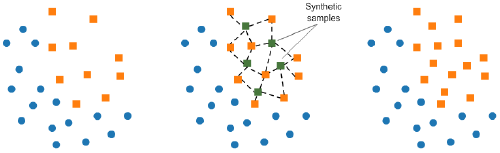

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preproc, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
y_train_res.value_counts()

## Undersampling - Random Under Sampler

Imagine RUS as a waste disposal unit that randomly discards some examples from the majority class to balance the dataset. By doing so, it makes the model focus more on the minority class. However, since it throws away data, it might discard useful information as well. So use RUS with caution!

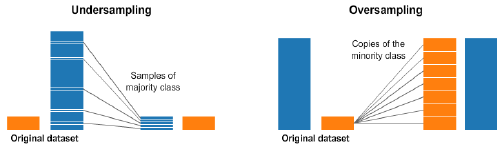

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_preproc, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
y_train_res.value_counts()


## Undersampling - Tomek Link

Tomek Links act like a magnet that attracts pairs of close majority and minority class examples (forming a 'link'). If a majority class example forms a Tomek Link, it's removed, helping to clean the borderline between classes. This removal of 'borderline' majority examples can make the model less biased towards the majority class. But, this method may not be sufficient if the imbalance is severe.

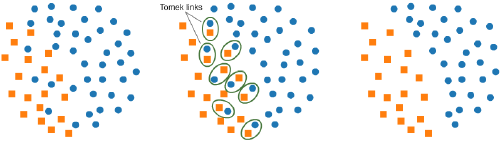

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_res, y_train_res = tl.fit_resample(X_train_preproc, y_train)

print(X_train_res.shape)
print(y_train_res.shape)
y_train_res.value_counts()
